# Assignment - 1


## Import Dependencies


In [65]:
import warnings
import pandas as pd
import numpy as np
import lightgbm as lgb
import joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)
from category_encoders import TargetEncoder, OrdinalEncoder

import gradio as gr
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots


plt.style.use("dark_background")
sns.set_palette("husl")
warnings.filterwarnings("ignore")

In [ ]:
class ChurnAnalyzer:
    def __init__(self, data_path):
        """Initialize the churn analyzer with data path"""
        self.data_path = data_path
        self.df = None
        self.X_train = None
        self.X_test = None
        self.y_train = None
        self.y_test = None
        self.scaler = StandardScaler()
        self.models = {}
        self.results = {}

    def load_and_explore_data(self):
        """Load data and perform initial exploration"""
        print("=" * 60)
        print("CUSTOMER CHURN PREDICTION ANALYSIS")
        print("=" * 60)

        # Load data
        self.df = pd.read_csv(self.data_path)
        print(f"\n📊 Dataset Shape: {self.df.shape}")
        print(f"📋 Features: {self.df.shape[1]} columns")
        print(f"📈 Samples: {self.df.shape[0]} rows")

        # Basic info about target variable
        churn_counts = self.df["Target_ChurnFlag"].value_counts()
        churn_rate = (churn_counts[1] / len(self.df)) * 100 if 1 in churn_counts else 0

        print("\n🎯 TARGET VARIABLE ANALYSIS:")
        print(f"   • Churn Rate: {churn_rate:.2f}%")
        print(f"   • Churned Customers: {churn_counts.get(1, 0)}")
        print(f"   • Retained Customers: {churn_counts.get(0, 0)}")

        # Missing values analysis
        missing_data = self.df.isnull().sum()
        missing_percent = (missing_data / len(self.df)) * 100
        missing_df = pd.DataFrame(
            {"Missing_Count": missing_data, "Missing_Percentage": missing_percent}
        ).sort_values("Missing_Percentage", ascending=False)

        print("\n MISSING DATA ANALYSIS:")
        print(f"   • Features with missing data: {(missing_data > 0).sum()}")
        if (missing_data > 0).sum() > 0:
            print("   • Top 5 features with most missing data:")
            print(missing_df.head().to_string())

        return self.df.head()

    def visualize_data(self):
        """Create visualizations for data exploration"""
        print("\n CREATING VISUALIZATIONS...")

        # Create subplots
        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle("Customer Churn Data Exploration", fontsize=16, fontweight="bold")

        # 1. Churn distribution
        churn_counts = self.df["Target_ChurnFlag"].value_counts()
        labels = ["Retained", "Churned"]
        axes[0, 0].pie(
            churn_counts.values, labels=labels, autopct="%1.1f%%", startangle=90
        )
        axes[0, 0].set_title("Churn Distribution")

        # 2. Missing data heatmap (top 20 features)
        missing_data = self.df.isnull().sum().sort_values(ascending=False).head(20)
        if len(missing_data) > 0:
            axes[0, 1].barh(range(len(missing_data)), missing_data.values)
            axes[0, 1].set_yticks(range(len(missing_data)))
            axes[0, 1].set_yticklabels(missing_data.index, fontsize=8)
            axes[0, 1].set_title("Top 20 Features with Missing Data")
            axes[0, 1].set_xlabel("Missing Count")

        # 3. Feature correlation with target (sample)
        numeric_cols = self.df.select_dtypes(include=[np.number]).columns
        numeric_cols = [col for col in numeric_cols if col != "Target_ChurnFlag"][:15]

        if len(numeric_cols) > 0:
            correlations = []
            for col in numeric_cols:
                try:
                    corr = self.df[col].corr(self.df["Target_ChurnFlag"])
                    if not np.isnan(corr):
                        correlations.append((col, abs(corr)))
                except Exception as e:
                    print(f"Error calculating correlation for {col}: {e}")
            if correlations:
                correlations.sort(key=lambda x: x[1], reverse=True)
                features, corr_values = zip(*correlations[:10])

                axes[1, 0].barh(range(len(features)), corr_values)
                axes[1, 0].set_yticks(range(len(features)))
                axes[1, 0].set_yticklabels(features, fontsize=8)
                axes[1, 0].set_title("Top 10 Features - Correlation with Churn")
                axes[1, 0].set_xlabel("Absolute Correlation")

        # 4. Data types distribution
        dtype_counts = self.df.dtypes.value_counts()
        axes[1, 1].pie(
            dtype_counts.values, labels=dtype_counts.index, autopct="%1.1f%%"
        )
        axes[1, 1].set_title("Data Types Distribution")

        plt.tight_layout()
        plt.show()

    def preprocess_data(self):
        """Preprocess data for modeling"""
        print("\n PREPROCESSING DATA...")

        # --- Step 1: Remove Duplicate and Unwanted Columns ---
        print("   • Identifying duplicate columns...")
        columns_to_remove = {"UID"}

        # Detect duplicate columns
        duplicates = []
        columns = self.df.columns

        for i in range(len(columns)):
            for j in range(i + 1, len(columns)):
                if self.df[columns[i]].equals(self.df[columns[j]]):
                    duplicates.append((columns[i], columns[j]))

        # Prepare columns to drop
        cols_to_drop = {dup[1] for dup in duplicates} | columns_to_remove
        self.df.drop(columns=cols_to_drop, errors="ignore", inplace=True)

        self.df = self.df.dropna(axis=1, how="any")
        self.df = self.df.drop_duplicates()

        constant_cols = [col for col in self.df.columns if self.df[col].nunique() == 1]
        self.df.drop(columns=constant_cols, inplace=True)
        print(f" • Dropped {len(cols_to_drop)} columns (duplicates and UID)")

        print(f"  Shape: {self.df.shape}")

        # --- Step 5: Categorical Encoding ---
        print("\n   • Encoding categorical variables...")

        # # Target encode high-cardinality features
        high_card_cols = ["X150", "X151", "X154", "X155"]
        high_card_cols = [
            col for col in high_card_cols if col in self.df.columns
        ]  # Ensure they exist
        if high_card_cols:
            encoder = TargetEncoder(cols=high_card_cols, smoothing=10)
            self.df = encoder.fit_transform(self.df, self.df["Target_ChurnFlag"])
            print(
                f"   • Encoded {len(high_card_cols)} high-cardinality features with Target Encoding"
            )
            joblib.dump(encoder, "target_encoder.pkl")

        # # Ordinal encode ordered categories
        ordinal_cols = ["X18"]
        ordinal_cols = [
            col for col in ordinal_cols if col in self.df.columns
        ]  # Ensure they exist
        if ordinal_cols:
            encoder = OrdinalEncoder(cols=ordinal_cols)
            self.df[ordinal_cols] = encoder.fit_transform(
                self.df[ordinal_cols], self.df["Target_ChurnFlag"]
            )
            joblib.dump(encoder, "ordinal_encoder.pkl")  # Save the encoder

        print(
            f"   • Encoded {len(ordinal_cols)} ordinal features with Ordinal Encoding"
        )

        # One-hot encode low-cardinality nominal features
        nominal_cols = ["X0", "X152", "X156", "X157", "X158"]
        nominal_cols = [
            col for col in nominal_cols if col in self.df.columns
        ]  # Ensure they exist
        if nominal_cols:
            self.df = pd.get_dummies(
                self.df,
                columns=nominal_cols,
                drop_first=True,  # Avoids dummy trap
                prefix_sep="_",
            )
        print(
            f"   • Encoded {len(nominal_cols)} nominal features with One-Hot Encoding"
        )

        for col in ["X2", "X3", "X5", "X6", "X30", "X31"]:
            if col in self.df.columns:
                print(f"   • Processing date column: {col}")
                self.df[col] = pd.to_datetime(self.df[col])
                self.df[f"{col}_days_since"] = (
                    pd.Timestamp.now() - self.df[col]
                ).dt.days
                self.df = self.df.drop(columns=col)  # Remove original date column
        print("   • Processed date columns to 'days since' format")

        X = self.df.drop(columns=["Target_ChurnFlag"])
        y = self.df["Target_ChurnFlag"]
        print(f"   • Features shape: {X.shape}, Target shape: {y.shape}")

        # print("\n   • Checking feature correlation with target variable...")

        # # Check correlation with target variable
        # corr = pd.concat([pd.DataFrame(X), pd.DataFrame(y)], axis=1).corr()[
        #     "Target_ChurnFlag"
        # ].abs().sort_values(ascending=False)
        # high_corr_features = corr[1:][corr[1:] > 0.1].index  # Only feature names
        # X = X.drop(columns=high_corr_features)  # Drop highly correlated features
        # print(f"   • Dropped {len(high_corr_features)} highly correlated features")
        # print(f"   • Remaining features shape: {X.shape}")

        # --- Step 6: Feature Scaling ---
        print("   • Scaling features...")

        self.scaler = StandardScaler()

        X = self.scaler.fit_transform(X)

        joblib.dump(self.scaler, "scaler.pkl")  # Save the scaler for future

        print("   • Features scaled using StandardScaler")
        print(f"   • Scaled features shape: {X.shape}")

        # Verify no NaN values after scaling
        if np.isnan(X).any():
            print("   ❌ NaN values found in scaled features")
        else:
            print("   • No NaN values in scaled features")
        # Convert scaled features back to DataFrame

        # # --- Step 7: Train-Test Split ---
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        print("\n   ✅ Preprocessing complete!")
        print(f"   • Final training set: {self.X_train.shape}")
        print(f"   • Final test set: {self.X_test.shape}")

        return X.shape

    def train_models(self):
        """Train multiple models"""
        print("\n🤖 TRAINING MODELS...")
        ratio = (len(self.y_train) - sum(self.y_train)) / sum(self.y_train)

        # Define models
        models = {
            "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
            "Gradient Boosting": GradientBoostingClassifier(random_state=42),
            "LightGBM": lgb.LGBMClassifier(
                objective="binary",
                n_estimators=1000,
                learning_rate=0.02,
                num_leaves=127,
                max_depth=-1,
                min_child_samples=100,
                subsample=0.9,
                colsample_bytree=0.8,
                reg_alpha=0.2,
                reg_lambda=0.2,
                scale_pos_weight=ratio,
                boosting_type="dart",
                metric="auc",
                random_state=42,
                n_jobs=-1,
            ),
        }

        print(
            f"   • Using scale_pos_weight = {ratio:.2f} for LightGBM to handle class imbalance"
        )

        # Train and evaluate each model
        for name, model in models.items():
            print(f"\n   Training {name}...")

            model.fit(self.X_train, self.y_train)
            y_pred = model.predict(self.X_test)
            y_pred_proba = model.predict_proba(self.X_test)[:, 1]

            # Calculate metrics
            accuracy = model.score(self.X_test, self.y_test)
            auc_score = roc_auc_score(self.y_test, y_pred_proba)

            # Cross-validation score
            cv_scores = cross_val_score(
                model,
                self.X_train if name != "SVM" else self.X_train_scaled,
                self.y_train,
                cv=5,
                scoring="roc_auc",
            )

            # Store results
            self.models[name] = model
            self.results[name] = {
                "accuracy": accuracy,
                "auc_score": auc_score,
                "cv_mean": cv_scores.mean(),
                "cv_std": cv_scores.std(),
                "predictions": y_pred,
                "probabilities": y_pred_proba,
            }

            print(f"     ✓ Accuracy: {accuracy:.4f}")
            print(f"     ✓ AUC Score: {auc_score:.4f}")
            print(f"     ✓ CV Score: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")

    def evaluate_models(self):
        """Evaluate and compare models"""
        print("\n MODEL EVALUATION RESULTS:")
        print("=" * 80)

        # Create results summary
        results_df = pd.DataFrame(
            {
                "Model": list(self.results.keys()),
                "Accuracy": [
                    self.results[model]["accuracy"] for model in self.results.keys()
                ],
                "AUC Score": [
                    self.results[model]["auc_score"] for model in self.results.keys()
                ],
                "CV Mean": [
                    self.results[model]["cv_mean"] for model in self.results.keys()
                ],
                "CV Std": [
                    self.results[model]["cv_std"] for model in self.results.keys()
                ],
            }
        ).sort_values("AUC Score", ascending=False)

        print(results_df.to_string(index=False, float_format="%.4f"))

        # Best model
        best_model_name = results_df.iloc[0]["Model"]
        print(f"\n BEST MODEL: {best_model_name}")
        print(f"   • AUC Score: {self.results[best_model_name]['auc_score']:.4f}")
        print(f"   • Accuracy: {self.results[best_model_name]['accuracy']:.4f}")

        # Detailed evaluation for best model
        print(f"\n📋 DETAILED EVALUATION - {best_model_name}:")
        y_pred = self.results[best_model_name]["predictions"]

        print("\nClassification Report:")
        print(classification_report(self.y_test, y_pred))

        print("\nConfusion Matrix:")
        cm = confusion_matrix(self.y_test, y_pred)
        print(cm)

        return best_model_name, results_df

    def create_model_comparison_plots(self):
        """Create visualization comparing models"""
        print("\n CREATING MODEL COMPARISON PLOTS...")

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle("Model Performance Comparison", fontsize=16, fontweight="bold")

        # 1. AUC Score comparison
        models = list(self.results.keys())
        auc_scores = [self.results[model]["auc_score"] for model in models]

        axes[0, 0].bar(models, auc_scores, color="skyblue")
        axes[0, 0].set_title("AUC Score Comparison")
        axes[0, 0].set_ylabel("AUC Score")
        axes[0, 0].tick_params(axis="x", rotation=45)

        # 2. Accuracy comparison
        accuracies = [self.results[model]["accuracy"] for model in models]
        axes[0, 1].bar(models, accuracies, color="lightcoral")
        axes[0, 1].set_title("Accuracy Comparison")
        axes[0, 1].set_ylabel("Accuracy")
        axes[0, 1].tick_params(axis="x", rotation=45)

        # 3. ROC Curves
        for model_name in models:
            y_pred_proba = self.results[model_name]["probabilities"]
            fpr, tpr, _ = roc_curve(self.y_test, y_pred_proba)
            auc_score = self.results[model_name]["auc_score"]
            axes[1, 0].plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.3f})")

        axes[1, 0].plot([0, 1], [0, 1], "k--", label="Random")
        axes[1, 0].set_xlabel("False Positive Rate")
        axes[1, 0].set_ylabel("True Positive Rate")
        axes[1, 0].set_title("ROC Curves")
        axes[1, 0].legend()
        axes[1, 0].grid(True)

        # 4. Cross-validation scores
        cv_means = [self.results[model]["cv_mean"] for model in models]
        cv_stds = [self.results[model]["cv_std"] for model in models]

        axes[1, 1].bar(models, cv_means, yerr=cv_stds, capsize=5, color="lightgreen")
        axes[1, 1].set_title("Cross-Validation Scores")
        axes[1, 1].set_ylabel("CV Score (Mean ± Std)")
        axes[1, 1].tick_params(axis="x", rotation=45)

        plt.tight_layout()
        plt.show()

    def generate_insights(self):
        """Generate insights"""

        # Churn rate analysis
        churn_rate = (self.df["Target_ChurnFlag"].sum() / len(self.df)) * 100

        print("📈 CURRENT SITUATION:")
        print(f"   • Overall churn rate: {churn_rate:.2f}%")
        print(f"   • Total customers analyzed: {len(self.df):,}")
        print(f"   • Customers at risk: {self.df['Target_ChurnFlag'].sum():,}")

        # Model performance insights
        best_model = max(
            self.results.keys(), key=lambda x: self.results[x]["auc_score"]
        )
        best_auc = self.results[best_model]["auc_score"]

        print("\n MODEL PERFORMANCE:")
        print(f"   • Best performing model: {best_model}")
        print(f"   • Prediction accuracy: {best_auc:.1%}")
        print(f"   • Model can identify {best_auc:.1%} of churners correctly")

        return {
            "churn_rate": churn_rate,
            "best_model": best_model,
            "best_auc": best_auc,
            "total_customers": len(self.df),
            "churned_customers": self.df["Target_ChurnFlag"].sum(),
        }

    def run_complete_analysis(self):
        """Run the complete analysis pipeline"""
        print("🚀 Starting Complete Churn Analysis Pipeline...\n")

        # Step 1: Load and explore data
        sample_data = self.load_and_explore_data()

        # Step 2: Visualize data
        self.visualize_data()

        # Step 3: Preprocess data
        data_shape = self.preprocess_data()

        # Step 5: Train models
        self.train_models()

        # Step 6: Evaluate models
        best_model, results_summary = self.evaluate_models()

        # Step 7: Create comparison plots
        self.create_model_comparison_plots()

        # Step 8: Generate insights
        insights = self.generate_insights()

        print("ANALYSIS COMPLETE!")
        print("Check the generated plots and results above.")

        return {
            "sample_data": sample_data,
            "data_shape": data_shape,
            "best_model": best_model,
            "results_summary": results_summary,
            "insights": insights,
        }


analyzer = ChurnAnalyzer("deepq_ai_assignment1_data.csv")

analyzer.run_complete_analysis()


In [ ]:
class ChurnPredictor:
    def __init__(self):
        # Load all the saved components
        self.models = {
            "Random Forest": joblib.load("models/random_forest_model.pkl"),
            "Gradient Boosting": joblib.load("models/gradient_boosting_model.pkl"),
            "LightGBM": joblib.load("models/lightgbm_model.pkl"),
        }
        self.scaler = joblib.load("models/preprocessor/scaler.pkl")
        self.target_encoder = joblib.load("models/preprocessor/target_encoder.pkl")
        self.ordinal_encoder = joblib.load("models/preprocessor/ordinal_encoder.pkl")

        # Load feature names from CSV
        try:
            self.feature_names = pd.read_csv("data/features.csv")["Feature"].tolist()
        except FileNotFoundError:
            raise Exception(
                "Feature names file not found. Please ensure 'features.csv' exists."
            )

    def preprocess_new_data(self, new_data: pd.DataFrame):
        """Preprocess new data in the same way as training data"""
        # Make a copy to avoid modifying original
        processed_data = new_data.copy()

        # 1. Drop the same columns that were dropped during training
        columns_to_remove = {"UID"}

        # Detect duplicate columns
        duplicates = []
        columns = processed_data.columns

        for i in range(len(columns)):
            for j in range(i + 1, len(columns)):
                if processed_data[columns[i]].equals(processed_data[columns[j]]):
                    duplicates.append((columns[i], columns[j]))

        # Prepare columns to drop
        cols_to_drop = {dup[1] for dup in duplicates} | columns_to_remove
        processed_data.drop(columns=cols_to_drop, errors="ignore", inplace=True)

        processed_data = processed_data.dropna(axis=1, how="any")

        constant_cols = [
            col for col in processed_data.columns if processed_data[col].nunique() == 1
        ]
        processed_data.drop(columns=constant_cols, inplace=True)

        # 2. Handle date columns
        date_cols = ["X2", "X3", "X5", "X6", "X30", "X31"]
        for col in date_cols:
            if col in processed_data.columns:
                processed_data[col] = pd.to_datetime(processed_data[col])
                processed_data[f"{col}_days_since"] = (
                    pd.Timestamp.now() - processed_data[col]
                ).dt.days
                processed_data = processed_data.drop(columns=col)

        # 3. Apply the same encodings
        high_card_cols = ["X150", "X151", "X154", "X155"]
        high_card_cols = [
            col for col in high_card_cols if col in processed_data.columns
        ]
        if high_card_cols:
            processed_data = self.target_encoder.transform(processed_data)

        ordinal_cols = ["X18"]
        ordinal_cols = [col for col in ordinal_cols if col in processed_data.columns]
        if ordinal_cols:
            processed_data[ordinal_cols] = self.ordinal_encoder.transform(
                processed_data[ordinal_cols]
            )

        # 4. One-hot encode nominal features
        nominal_cols = ["X0", "X152", "X156", "X157", "X158"]
        nominal_cols = [col for col in nominal_cols if col in processed_data.columns]
        if nominal_cols:
            processed_data = pd.get_dummies(
                processed_data, columns=nominal_cols, drop_first=True, prefix_sep="_"
            )

        # 5. Ensure we have all expected columns (add missing with 0s)
        for col in self.feature_names:
            if col not in processed_data.columns:
                processed_data[col] = 0

        # 6. Reorder columns to match training data
        processed_data = processed_data[self.feature_names]

        # 7. Scale the features
        scaled_data = self.scaler.transform(processed_data)

        return scaled_data


In [ ]:
class ChurnPredictorApp(ChurnPredictor):
    def __init__(self):
        """Initialize the predictor with all saved models and preprocessors"""
        super().__init__()

        # Ensure all models are loaded
        if not self.models:
            raise Exception(
                "No models found. Please ensure models are saved correctly."
            )

    def predict_all_models(self, csv_file):
        """Make predictions using all three models"""
        try:
            # Read the CSV file
            df = pd.read_csv(csv_file.name)

            # Check if file is empty
            if df.empty:
                return "Error: The uploaded file is empty."

            # Preprocess the data
            processed_data = self.preprocess_new_data(df)

            # Get predictions from all models
            predictions = {}
            probabilities = {}

            for model_name, model in self.models.items():
                pred = model.predict(processed_data)
                prob = model.predict_proba(processed_data)[:, 1]
                predictions[model_name] = pred
                probabilities[model_name] = prob

            # Create results dataframe
            results_df = df.copy()
            for model_name in self.models.keys():
                results_df[f"{model_name}_Prediction"] = predictions[model_name]
                results_df[f"{model_name}_Churn_Probability"] = probabilities[
                    model_name
                ]

            # Generate summary statistics
            summary_stats = self.generate_summary_stats(
                predictions, probabilities, len(df)
            )

            # Create visualizations
            prob_dist_plot = self.create_probability_distribution_plot(probabilities)
            model_comparison_plot = self.create_model_comparison_plot(
                predictions, probabilities
            )
            churn_risk_plot = self.create_churn_risk_segments_plot(probabilities)
            prediction_summary_plot = self.create_prediction_summary_plot(predictions)

            return (
                summary_stats,
                prob_dist_plot,
                model_comparison_plot,
                churn_risk_plot,
                prediction_summary_plot,
                results_df,
            )

        except Exception as e:
            error_msg = f"Error processing file: {str(e)}"
            return error_msg, None, None, None, None, None

    def generate_summary_stats(self, predictions, probabilities, total_samples):
        """Generate summary statistics"""
        stats = f"""
        📊 **PREDICTION SUMMARY**
        
        **Dataset Info:**
        - Total Customers Analyzed: {total_samples:,}
        
        **Churn Predictions by Model:**
        """

        for model_name in predictions.keys():
            churn_count = sum(predictions[model_name])
            churn_rate = (churn_count / total_samples) * 100
            avg_prob = np.mean(probabilities[model_name])

            stats += f"""
        **{model_name}:**
        - Predicted Churners: {churn_count:,} ({churn_rate:.1f}%)
        - Average Churn Probability: {avg_prob:.3f}
        - High Risk Customers (>70% prob): {sum(probabilities[model_name] > 0.7):,}
            """

        return stats

    def create_probability_distribution_plot(self, probabilities):
        """Create probability distribution plot for all models"""
        fig = make_subplots(
            rows=1,
            cols=3,
            subplot_titles=list(probabilities.keys()),
            horizontal_spacing=0.1,
        )

        colors = ["#FF6B6B", "#4ECDC4", "#45B7D1"]

        for i, (model_name, probs) in enumerate(probabilities.items()):
            fig.add_trace(
                go.Histogram(
                    x=probs,
                    nbinsx=30,
                    name=model_name,
                    marker_color=colors[i],
                    opacity=0.7,
                ),
                row=1,
                col=i + 1,
            )

        fig.update_layout(
            title_text="Churn Probability Distributions by Model",
            title_x=0.5,
            height=400,
            showlegend=False,
        )

        fig.update_xaxes(title_text="Churn Probability")
        fig.update_yaxes(title_text="Number of Customers")

        return fig

    def create_model_comparison_plot(self, predictions, probabilities):
        """Create model comparison plot"""
        fig = make_subplots(
            rows=2,
            cols=2,
            subplot_titles=[
                "Predicted Churn Counts",
                "Average Churn Probabilities",
                "High Risk Customers (>70%)",
                "Medium Risk Customers (30-70%)",
            ],
            specs=[
                [{"type": "bar"}, {"type": "bar"}],
                [{"type": "bar"}, {"type": "bar"}],
            ],
        )

        model_names = list(predictions.keys())
        colors = ["#FF6B6B", "#4ECDC4", "#45B7D1"]

        # Churn counts
        churn_counts = [sum(predictions[model]) for model in model_names]
        fig.add_trace(
            go.Bar(
                x=model_names,
                y=churn_counts,
                name="Churn Count",
                marker_color=colors,
                text=churn_counts,
                textposition="auto",
            ),
            row=1,
            col=1,
        )

        # Average probabilities
        avg_probs = [np.mean(probabilities[model]) for model in model_names]
        fig.add_trace(
            go.Bar(
                x=model_names,
                y=avg_probs,
                name="Avg Probability",
                marker_color=colors,
                text=[f"{p:.3f}" for p in avg_probs],
                textposition="auto",
            ),
            row=1,
            col=2,
        )

        # High risk customers
        high_risk = [sum(probabilities[model] > 0.7) for model in model_names]
        fig.add_trace(
            go.Bar(
                x=model_names,
                y=high_risk,
                name="High Risk",
                marker_color=colors,
                text=high_risk,
                textposition="auto",
            ),
            row=2,
            col=1,
        )

        # Medium risk customers
        medium_risk = [
            sum((probabilities[model] >= 0.3) & (probabilities[model] <= 0.7))
            for model in model_names
        ]
        fig.add_trace(
            go.Bar(
                x=model_names,
                y=medium_risk,
                name="Medium Risk",
                marker_color=colors,
                text=medium_risk,
                textposition="auto",
            ),
            row=2,
            col=2,
        )

        fig.update_layout(
            title_text="Model Performance Comparison",
            title_x=0.5,
            height=600,
            showlegend=False,
        )

        return fig

    def create_churn_risk_segments_plot(self, probabilities):
        """Create churn risk segmentation plot"""
        # Define risk categories
        risk_categories = [
            "Low Risk (0-30%)",
            "Medium Risk (30-70%)",
            "High Risk (70%+)",
        ]

        fig = go.Figure()

        colors = ["#2ECC71", "#F39C12", "#E74C3C"]
        model_names = list(probabilities.keys())

        for i, model_name in enumerate(model_names):
            probs = probabilities[model_name]
            low_risk = sum(probs < 0.3)
            medium_risk = sum((probs >= 0.3) & (probs < 0.7))
            high_risk = sum(probs >= 0.7)

            fig.add_trace(
                go.Bar(
                    name=model_name,
                    x=risk_categories,
                    y=[low_risk, medium_risk, high_risk],
                    text=[low_risk, medium_risk, high_risk],
                    textposition="auto",
                    marker_color=colors,
                    opacity=0.8,
                    yaxis=f"y{i + 1}" if i > 0 else "y",
                    offsetgroup=i,
                )
            )

        fig.update_layout(
            title="Customer Risk Segmentation by Model",
            title_x=0.5,
            xaxis_title="Risk Categories",
            yaxis_title="Number of Customers",
            barmode="group",
            height=500,
            legend=dict(
                orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1
            ),
        )

        return fig

    def create_prediction_summary_plot(self, predictions):
        """Create prediction summary pie charts"""
        fig = make_subplots(
            rows=1,
            cols=3,
            specs=[[{"type": "pie"}, {"type": "pie"}, {"type": "pie"}]],
            subplot_titles=list(predictions.keys()),
        )

        colors = ["#2ECC71", "#E74C3C"]  # Green for No Churn, Red for Churn

        for i, (model_name, preds) in enumerate(predictions.items()):
            churn_count = sum(preds)
            no_churn_count = len(preds) - churn_count

            fig.add_trace(
                go.Pie(
                    labels=["No Churn", "Churn"],
                    values=[no_churn_count, churn_count],
                    name=model_name,
                    marker_colors=colors,
                    textinfo="label+percent",
                    textposition="auto",
                ),
                row=1,
                col=i + 1,
            )

        fig.update_layout(
            title_text="Churn vs No-Churn Predictions",
            title_x=0.5,
            height=400,
            showlegend=True,
        )

        return fig


predictor_app = ChurnPredictorApp()


# Create Gradio interface
def predict_churn(csv_file):
    if csv_file is None:
        return "Please upload a CSV file.", None, None, None, None, None

    return predictor_app.predict_all_models(csv_file)


# Create the Gradio app
with gr.Blocks(
    title="Customer Churn Prediction System",
    theme=gr.themes.Soft(),
    css="""
    .gradio-container {
        max-width: 1200px !important;
    }
    """,
) as app:
    gr.Markdown("""
    # 🎯 Customer Churn Prediction System
    - **Random Forest**: Ensemble method using multiple decision trees
    - **Gradient Boosting**: Sequential ensemble method for improved accuracy  
    - **LightGBM**: Optimized gradient boosting framework
    

    """)

    with gr.Row():
        with gr.Column(scale=1):
            csv_input = gr.File(
                label="📁 Upload CSV File", file_types=[".csv"], type="filepath"
            )

            predict_btn = gr.Button("🚀 Predict Churn", variant="primary", size="lg")

    with gr.Row():
        summary_output = gr.Markdown(label="📈 Prediction Summary")

    with gr.Tab("📊 Visualizations"):
        with gr.Row():
            prob_dist_plot = gr.Plot(label="Probability Distributions")

        with gr.Row():
            model_comparison_plot = gr.Plot(label="Model Comparison")

        with gr.Row():
            churn_risk_plot = gr.Plot(label="Risk Segmentation")

        with gr.Row():
            prediction_summary_plot = gr.Plot(label="Prediction Summary")

    with gr.Tab("📋 Detailed Results"):
        results_table = gr.Dataframe(
            label="Complete Results with Predictions", interactive=False, wrap=True
        )

    # Set up the prediction function
    predict_btn.click(
        fn=predict_churn,
        inputs=[csv_input],
        outputs=[
            summary_output,
            prob_dist_plot,
            model_comparison_plot,
            churn_risk_plot,
            prediction_summary_plot,
            results_table,
        ],
    )

    gr.Markdown("""
    ## Model Information:
    
    **Risk Categories:**
    - 🟢 **Low Risk (0-30%)**: Customers unlikely to churn
    - 🟡 **Medium Risk (30-70%)**: Customers requiring attention  
    - 🔴 **High Risk (70%+)**: Customers at high risk of churning
    
   
    """)

    # Launch the app

app.launch(show_error=True)


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


# Assignment - 2


RETAIL CUSTOMER ANALYSIS - COMPLETE SOLUTION
Loading datasets...
✓ All datasets loaded successfully

PROBLEM 1: MERGING DATASETS
✓ Datasets merged successfully!
✓ Final dataset 'Customer_Final' created with 99293 records

PROBLEM 2: SUMMARY REPORT

A. COLUMN NAMES AND DATATYPES:
----------------------------------------
           Column Data_Type  Non_Null_Count
      customer_Id     int64           99293
              DOB    object           99293
           Gender    object           99253
        city_code   float64           99257
   transaction_id    object           99293
        tran_date    object           99293
 prod_subcat_code     int64           99293
    prod_cat_code     int64           99293
              Qty     int64           99293
             Rate     int64           99293
              Tax   float64           99293
        total_amt   float64           99293
       Store_type    object           99293
         prod_cat    object           99293
prod_sub_cat_code  

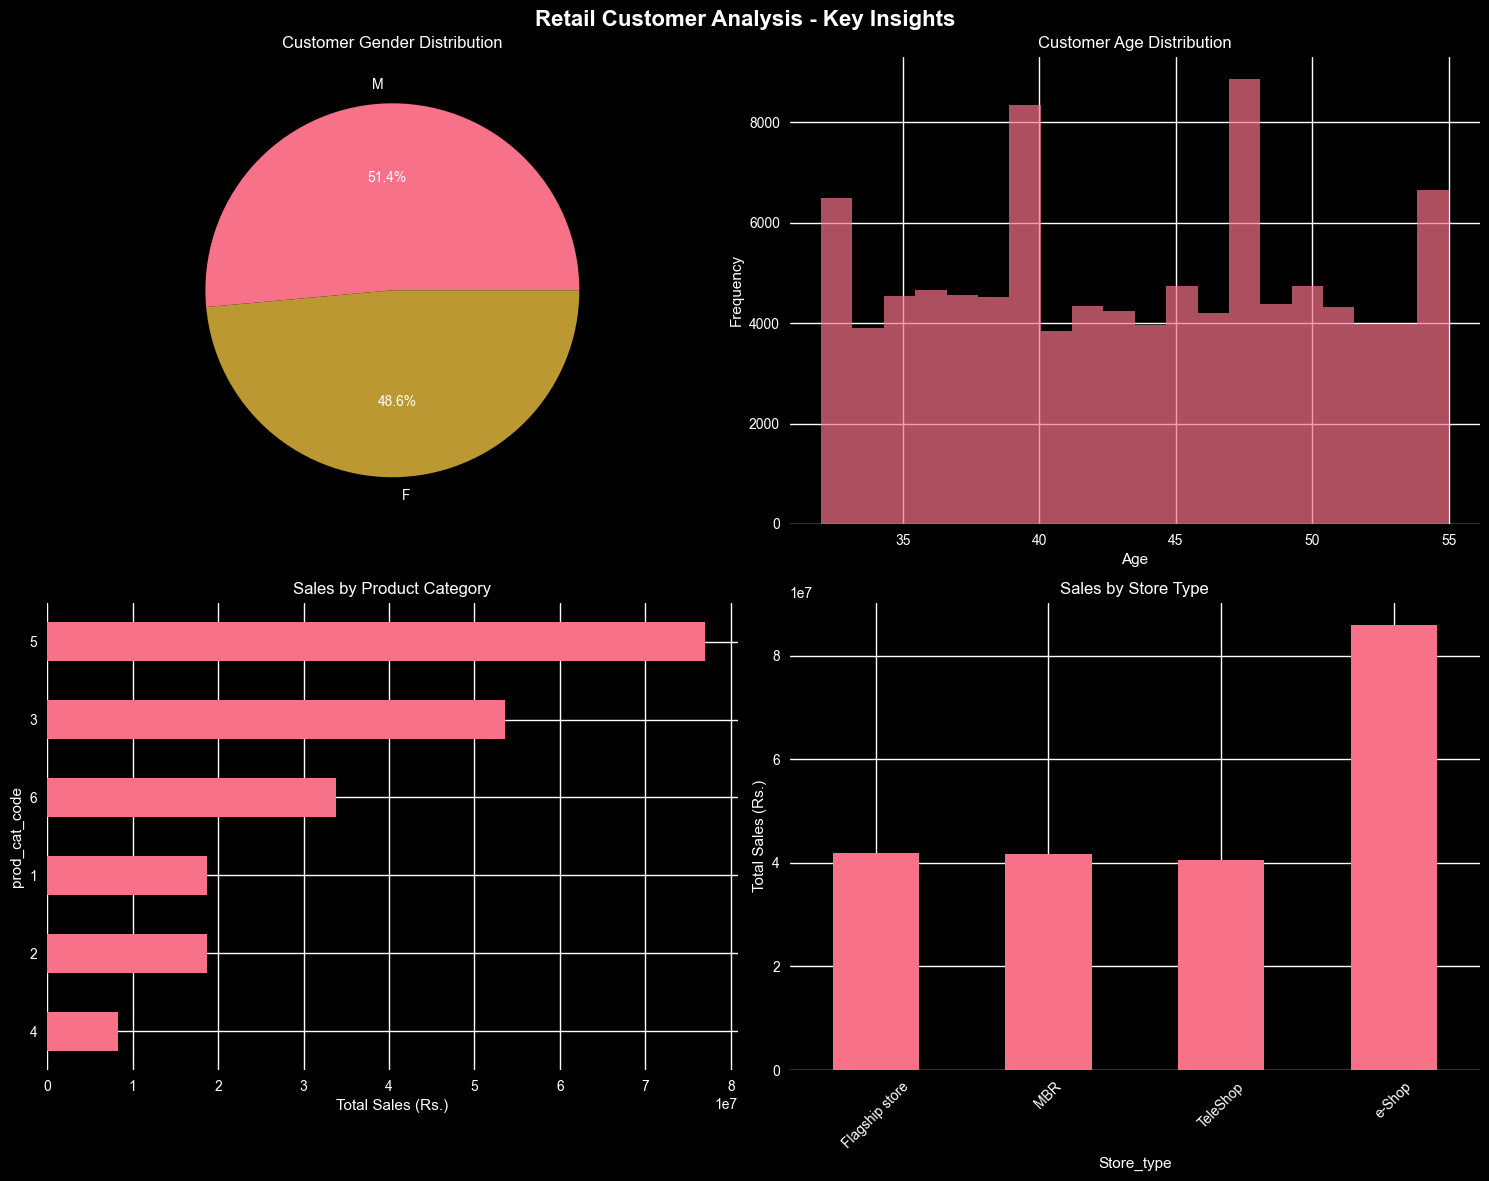


ANALYSIS COMPLETE!


In [68]:
class Assignment2:
    def __init__(self):
        self.customer_final = None
        self.customers = None
        self.transactions = None
        self.product_hierarchy = None

    def load_data(self, customer_file, transaction_file, product_file):
        """Load the three datasets"""
        print("Loading datasets...")
        try:
            self.customers = pd.read_csv(customer_file)
            self.transactions = pd.read_csv(transaction_file)
            self.product_hierarchy = pd.read_csv(product_file)
            print("✓ All datasets loaded successfully")
        except Exception as e:
            print(f"Error loading data: {e}")
            return False
        return True

    def merge_datasets(self):
        """Problem 1: Merge datasets to create Customer_Final"""
        print("\n" + "=" * 50)
        print("PROBLEM 1: MERGING DATASETS")
        print("=" * 50)

        trans_product = pd.merge(
            self.transactions, self.product_hierarchy, on="prod_cat_code", how="left"
        )

        trans_product.rename(
            columns={
                "cust_id": "customer_Id",
            },
            inplace=True,
        )

        self.customer_final = pd.merge(
            self.customers, trans_product, on="customer_Id", how="inner"
        )

        print("✓ Datasets merged successfully!")
        print(
            f"✓ Final dataset 'Customer_Final' created with {len(self.customer_final)} records"
        )

        return self.customer_final

    def generate_summary_report(self):
        """Problem 2: Generate comprehensive summary report"""
        print("\n" + "=" * 50)
        print("PROBLEM 2: SUMMARY REPORT")
        print("=" * 50)

        df = self.customer_final

       
        print("\nA. COLUMN NAMES AND DATATYPES:")
        print("-" * 40)
        dtypes_info = pd.DataFrame(
            {"Column": df.columns, "Data_Type": df.dtypes, "Non_Null_Count": df.count()}
        )
        print(dtypes_info.to_string(index=False))

     
        print("\nB. TOP 20 OBSERVATIONS:")
        print("-" * 40)
        print(df.head(20).to_string())

        print("\nB. BOTTOM 20 OBSERVATIONS:")
        print("-" * 40)
        print(df.tail(20).to_string())


        print(f"\nC. TOTAL NUMBER OF ROWS: {len(df)}")


        print("\nD. MISSING VALUES COUNT:")
        print("-" * 40)
        missing_values = df.isnull().sum()
        missing_df = pd.DataFrame(
            {
                "Column": missing_values.index,
                "Missing_Count": missing_values.values,
                "Missing_Percentage": (missing_values.values / len(df) * 100).round(2),
            }
        )
        print(missing_df.to_string(index=False))

   
        print("\nE. FIVE-NUMBER SUMMARY (CONTINUOUS VARIABLES):")
        print("-" * 40)
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        five_num_summary = df[numeric_cols].describe()
        print(five_num_summary.to_string())

    
        print("\nF. FREQUENCY TABLES (CATEGORICAL VARIABLES):")
        print("-" * 40)
        categorical_cols = df.select_dtypes(include=["object"]).columns
        for col in categorical_cols:
            print(f"\nFrequency table for {col}:")
            freq_table = (
                df[col].value_counts().head(10)
            )  
            print(freq_table.to_string())

    def analyze_transaction_period_and_negatives(self):
        """Problem 3: Time period and negative transactions"""
        print("\n" + "=" * 50)
        print("PROBLEM 3: TRANSACTION ANALYSIS")
        print("=" * 50)

        df = self.customer_final

        date_cols = [
            col for col in df.columns if "date" in col.lower() or "Date" in col
        ]
        if date_cols:
            date_col = date_cols[0]  # Assume first date column is transaction date
            df[date_col] = pd.to_datetime(df[date_col], errors="coerce")

            min_date = df[date_col].min()
            max_date = df[date_col].max()
            print("A. TRANSACTION TIME PERIOD:")
            print(f"   From: {min_date}")
            print(f"   To: {max_date}")
            print(f"   Duration: {(max_date - min_date).days} days")

        amount_cols = [
            col
            for col in df.columns
            if "total_amt" in col.lower() or "Total_amt" in col
        ]
        if amount_cols:
            amount_col = amount_cols[0]  # Assume first amount column
            negative_transactions = (df[amount_col] < 0).sum()
            print(f"\nB. NEGATIVE TRANSACTIONS COUNT: {negative_transactions}")
        else:
            print("\nB. No amount column found for negative transaction analysis")

    def analyze_gender_product_preferences(self):
        """Problem 4: Product categories by gender"""
        print("\n" + "=" * 50)
        print("PROBLEM 4: PRODUCT PREFERENCES BY GENDER")
        print("=" * 50)

        df = self.customer_final


        gender_cols = [
            col for col in df.columns if "gender" in col.lower() or "Gender" in col
        ]
        category_cols = [
            col
            for col in df.columns
            if "prod_cat_code" in col.lower() or "prod_cat_code" in col
        ]

        if gender_cols and category_cols:
            gender_col = gender_cols[0]
            category_col = category_cols[0]

 
            gender_category = pd.crosstab(
                df[gender_col], df[category_col], margins=True
            )
            print("PRODUCT CATEGORY PREFERENCES BY GENDER:")
            print(gender_category.to_string())

 
            print("\nPERCENTAGE DISTRIBUTION:")
            gender_category_pct = (
                pd.crosstab(df[gender_col], df[category_col], normalize="index") * 100
            )
            print(gender_category_pct.round(2).to_string())
        else:
            print("Gender or Category columns not found")

    def analyze_city_distribution(self):
        """Problem 5: City with maximum customers"""
        print("\n" + "=" * 50)
        print("PROBLEM 5: CITY CUSTOMER DISTRIBUTION")
        print("=" * 50)

        df = self.customer_final

        city_cols = [
            col for col in df.columns if "city" in col.lower() or "City" in col
        ]

        if city_cols:
            city_col = city_cols[0]

            unique_customers_per_city = (
                df.groupby(city_col)["customer_Id"]
                .nunique()
                .sort_values(ascending=False)
            )
            total_customers = df["customer_Id"].nunique()

            max_city = unique_customers_per_city.index[0]
            max_city_count = unique_customers_per_city.iloc[0]
            max_city_percentage = (max_city_count / total_customers) * 100

            print(f"CITY WITH MAXIMUM CUSTOMERS: {max_city}")
            print(f"Number of customers: {max_city_count}")
            print(f"Percentage of total customers: {max_city_percentage:.2f}%")

            print("\nTOP 10 CITIES BY CUSTOMER COUNT:")
            print(unique_customers_per_city.head(10).to_string())
        else:
            print("City column not found")

    def analyze_store_performance(self):
        """Problem 6: Store type performance"""
        print("\n" + "=" * 50)
        print("PROBLEM 6: STORE TYPE PERFORMANCE")
        print("=" * 50)

        df = self.customer_final

        store_cols = [
            col
            for col in df.columns
            if "store" in col.lower() and "type" in col.lower()
        ]
        amount_cols = [
            col
            for col in df.columns
            if "total_amt" in col.lower() or "total_amt" in col
        ]
        qty_cols = [
            col
            for col in df.columns
            if "qty" in col.lower() or "quantity" in col.lower() or "Qty" in col
        ]

        if store_cols:
            store_col = store_cols[0]

            if amount_cols:
                amount_col = amount_cols[0]
                # Sales by value
                sales_by_value = (
                    df.groupby(store_col)[amount_col].sum().sort_values(ascending=False)
                )
                print("STORE TYPE PERFORMANCE BY VALUE:")
                print(sales_by_value.to_string())
                print(
                    f"\nMAXIMUM SALES BY VALUE: {sales_by_value.index[0]} (Rs.{sales_by_value.iloc[0]:,.2f})"
                )

            if qty_cols:
                qty_col = qty_cols[0]
                # Sales by quantity
                sales_by_qty = (
                    df.groupby(store_col)[qty_col].sum().sort_values(ascending=False)
                )
                print("\nSTORE TYPE PERFORMANCE BY QUANTITY:")
                print(sales_by_qty.to_string())
                print(
                    f"\nMAXIMUM SALES BY QUANTITY: {sales_by_qty.index[0]} ({sales_by_qty.iloc[0]:,} units)"
                )
        else:
            print("Store type column not found")

    def analyze_flagship_electronics_clothing(self):
        """Problem 7: Electronics and Clothing from Flagship stores"""
        print("\n" + "=" * 50)
        print("PROBLEM 7: FLAGSHIP STORE - ELECTRONICS & CLOTHING")
        print("=" * 50)

        df = self.customer_final

        # Find relevant columns
        store_cols = [
            col
            for col in df.columns
            if "store" in col.lower() and "type" in col.lower()
        ]
        category_cols = [
            col for col in df.columns if "prod_cat" in col.lower() or "prod_cat" in col
        ]
        amount_cols = [
            col
            for col in df.columns
            if "total_amt" in col.lower() or "Total_amt" in col
        ]

        if store_cols and category_cols and amount_cols:
            store_col = store_cols[0]
            category_col = category_cols[1]
            amount_col = amount_cols[0]

            flagship_data = df[
                df[store_col].str.contains("Flagship", case=False, na=False)
            ]
            target_categories = flagship_data[
                flagship_data[category_col].isin(["Electronics", "Clothing"])
            ]

            total_amount = target_categories[amount_col].sum()
            category_breakdown = target_categories.groupby(category_col)[
                amount_col
            ].sum()

            print(
                f"TOTAL AMOUNT FROM ELECTRONICS & CLOTHING (FLAGSHIP): Rs.{total_amount:,.2f}"
            )
            print("\nBREAKDOWN BY CATEGORY:")
            print(category_breakdown.to_string())
        else:
            print("Required columns not found")

    def analyze_male_electronics(self):
        """Problem 8: Male customers in Electronics"""
        print("\n" + "=" * 50)
        print("PROBLEM 8: MALE CUSTOMERS - ELECTRONICS")
        print("=" * 50)

        df = self.customer_final

        # Find relevant columns
        gender_cols = [
            col for col in df.columns if "gender" in col.lower() or "Gender" in col
        ]
        category_cols = [col for col in df.columns if "prod_cat" in col]
        print(category_cols)
        amount_cols = [
            col
            for col in df.columns
            if "total_amt" in col.lower() or "total_amt" in col
        ]

        if gender_cols and category_cols and amount_cols:
            gender_col = gender_cols[0]
            category_col = category_cols[1]
            amount_col = amount_cols[0]

            # Filter for Male customers and Electronics category
            male_electronics = df[
                (df[gender_col].str.contains("M", case=False, na=False))
                & (df[category_col] == "Electronics")
            ]

            total_amount = male_electronics[amount_col].sum()
            customer_count = male_electronics["customer_Id"].nunique()

            print(
                f"TOTAL AMOUNT FROM MALE CUSTOMERS (ELECTRONICS): Rs.{total_amount:,.2f}"
            )
            print(f"NUMBER OF UNIQUE MALE CUSTOMERS: {customer_count}")
        else:
            print("Required columns not found")

    def analyze_high_transaction_customers(self):
        """Problem 9: Customers with >10 unique transactions (excluding negative amounts)"""
        print("\n" + "=" * 50)
        print("PROBLEM 9: HIGH-TRANSACTION CUSTOMERS")
        print("=" * 50)

        df = self.customer_final

        amount_cols = [
            col
            for col in df.columns
            if "total_amt" in col.lower() or "Total_amt" in col
        ]

        if amount_cols:
            amount_col = amount_cols[0]

     
            positive_transactions = df[df[amount_col] >= 0]

           
            transaction_cols = [
                col
                for col in df.columns
                if "transaction" in col.lower() or "Transaction" in col
            ]
            if transaction_cols:
                transaction_col = transaction_cols[0]
                customer_transaction_counts = positive_transactions.groupby(
                    "customer_Id"
                )[transaction_col].nunique()
            else:
                customer_transaction_counts = positive_transactions.groupby(
                    "customer_Id"
                ).size()

            high_transaction_customers = customer_transaction_counts[
                customer_transaction_counts > 10
            ]

            print(
                f"CUSTOMERS WITH >10 UNIQUE TRANSACTIONS: {len(high_transaction_customers)}"
            )
            print(
                f"AVERAGE TRANSACTIONS PER HIGH-ACTIVITY CUSTOMER: {high_transaction_customers.mean():.2f}"
            )
        else:
            print("Amount column not found")

    def analyze_age_group_spending(self):
        """Problem 10: Age group 25-35 analysis"""
        print("\n" + "=" * 50)
        print("PROBLEM 10: AGE GROUP 25-35 ANALYSIS")
        print("=" * 50)

        df = self.customer_final

        if "DOB" in df.columns:
            df["DOB"] = pd.to_datetime(df["DOB"], format="%d-%m-%Y", errors="coerce")
        else:
            print("DOB column not found. Cannot analyze age group.")
            return

        df["age"] = (pd.Timestamp.now() - df["DOB"]).dt.days // 365

        age_cols = [col for col in df.columns if "age" in col.lower() or "Age" in col]

        category_cols = [
            col for col in df.columns if "prod_cat" in col.lower() or "Category" in col
        ]
        amount_cols = [
            col
            for col in df.columns
            if "total_amt" in col.lower() or "Total_amt" in col
        ]
        date_cols = [
            col for col in df.columns if "date" in col.lower() or "Date" in col
        ]

        if age_cols:
            age_col = age_cols[0]

            # Filter for age group 25-35
            age_group = df[(df[age_col] >= 25) & (df[age_col] <= 35)]

            if category_cols and amount_cols:
                category_col = category_cols[1]
                amount_col = amount_cols[0]

                electronics_books = age_group[
                    age_group[category_col].isin(["Electronics", "Books"])
                ]
                total_electronics_books = electronics_books.groupby(category_col)[
                    amount_col
                ].sum()

                print("A. SPENDING ON ELECTRONICS & BOOKS (AGE 25-35):")
                print(total_electronics_books.to_string())
                print(f"   Total: Rs.{total_electronics_books.sum():,.2f}")

                if date_cols:
                    date_col = date_cols[0]
                    age_group[date_col] = pd.to_datetime(
                        age_group[date_col], errors="coerce"
                    )

                    period_data = age_group[
                        (age_group[date_col] >= "2014-01-01")
                        & (age_group[date_col] <= "2014-03-01")
                    ]

                    period_spending = period_data[amount_col].sum()

                    print(
                        f"\nB. SPENDING (JAN 1 - MAR 1, 2014): Rs.{period_spending:,.2f}"
                    )
                    print(f"   Number of transactions in period: {len(period_data)}")
        else:
            print("Age column not found")

    def generate_visualization_report(self):
        """Generate visualizations for key insights"""
        print("\n" + "=" * 50)
        print("GENERATING VISUALIZATION REPORT")
        print("=" * 50)

        df = self.customer_final

        fig, axes = plt.subplots(2, 2, figsize=(15, 12))
        fig.suptitle(
            "Retail Customer Analysis - Key Insights", fontsize=16, fontweight="bold"
        )

        try:
            # 1. Gender distribution
            gender_cols = [
                col for col in df.columns if "gender" in col.lower() or "Gender" in col
            ]
            if gender_cols:
                gender_col = gender_cols[0]
                df[gender_col].value_counts().plot(
                    kind="pie", ax=axes[0, 0], autopct="%1.1f%%"
                )
                axes[0, 0].set_title("Customer Gender Distribution")
                axes[0, 0].set_ylabel("")

            # 2. Age distribution
            age_cols = [
                col for col in df.columns if "age" in col.lower() or "Age" in col
            ]
            if age_cols:
                age_col = age_cols[0]
                df[age_col].hist(bins=20, ax=axes[0, 1], alpha=0.7)
                axes[0, 1].set_title("Customer Age Distribution")
                axes[0, 1].set_xlabel("Age")
                axes[0, 1].set_ylabel("Frequency")

            # 3. Category sales
            category_cols = [
                col
                for col in df.columns
                if "prod_cat" in col.lower() or "prod_cat" in col
            ]
            amount_cols = [
                col
                for col in df.columns
                if "total_amt" in col.lower() or "Total_amt" in col
            ]
            if category_cols and amount_cols:
                category_col = category_cols[0]
                amount_col = amount_cols[0]
                category_sales = (
                    df.groupby(category_col)[amount_col]
                    .sum()
                    .sort_values(ascending=True)
                )
                category_sales.plot(kind="barh", ax=axes[1, 0])
                axes[1, 0].set_title("Sales by Product Category")
                axes[1, 0].set_xlabel("Total Sales (Rs.)")

            # 4. Store type performance
            store_cols = [
                col
                for col in df.columns
                if "store" in col.lower() and "type" in col.lower()
            ]
            if store_cols and amount_cols:
                store_col = store_cols[0]
                amount_col = amount_cols[0]
                store_sales = df.groupby(store_col)[amount_col].sum()
                store_sales.plot(kind="bar", ax=axes[1, 1])
                axes[1, 1].set_title("Sales by Store Type")
                axes[1, 1].set_ylabel("Total Sales (Rs.)")
                axes[1, 1].tick_params(axis="x", rotation=45)

            plt.tight_layout()
            plt.show()

        except Exception as e:
            print(f"Visualization error: {e}")

    def run_complete_analysis(self, customer_file, transaction_file, product_file):
        """Run the complete analysis pipeline"""
        print("RETAIL CUSTOMER ANALYSIS - COMPLETE SOLUTION")
        print("=" * 60)

        # Load and merge data
        if not self.load_data(customer_file, transaction_file, product_file):
            return

        self.merge_datasets()

        # Run all analyses
        self.generate_summary_report()
        self.analyze_transaction_period_and_negatives()
        self.analyze_gender_product_preferences()
        self.analyze_city_distribution()
        self.analyze_store_performance()
        self.analyze_flagship_electronics_clothing()
        self.analyze_male_electronics()
        self.analyze_high_transaction_customers()
        self.analyze_age_group_spending()

        # # Generate visualizations
        self.generate_visualization_report()

        print("\n" + "=" * 60)
        print("ANALYSIS COMPLETE!")
        print("=" * 60)


# Example usage:
if __name__ == "__main__":
    # Initialize the analyzer
    analyzer = Assignment2()

    # Replace these with your actual file paths
    customer_file = "Case Study 1 - Retail/Customer.csv"
    transaction_file = "Case Study 1 - Retail/Transactions.csv"
    product_file = "Case Study 1 - Retail/Product Hierarchy.csv"

    # Run the complete analysis
    analyzer.run_complete_analysis(customer_file, transaction_file, product_file)
